In [1]:
import os
cwd=os.getcwd()

cwd_data=cwd+'/data'

if not os.path.exists(cwd_data):
    os.mkdir(cwd_data)

In [3]:
import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import xarray as xr # x-array
import numpy as np # numpy
import pandas as pd
import urllib.request # download request
import warnings # to suppress warnings
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from sklearn.cluster import k_means # to perform k-means
from collections import Counter # set operations
warnings.filterwarnings('ignore')

In [4]:
tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)
tks = tks.drop_dims("quadrant") 

# Define functions

In [5]:
def get_lon_lat(storm):
  lon_lst = storm.lon.values
  lat_lst = storm.lat.values
  return lon_lst[~np.isnan(lon_lst)], lat_lst[~np.isnan(lat_lst)]

In [6]:
def get_moments(storm):
  # A function to calculate the track moments given a storm
  # OUTPUT:
  # X-centroid, Y-centroid, X_var, Y_var, XY_var

  # Note that:
  # In this case, no weights are set. In other words, all weights are 1.
  # A weight variable would need to be added in order to explore other weights

  lon_lst, lat_lst = get_lon_lat(storm)
  # If the track only has one point, there is no point in calculating the moments
  if len(lon_lst)<= 1: return None
      
  # M1 (first moment = mean). 
  # No weights applied
  lon_weighted, lat_weighted = np.mean(lon_lst), np.mean(lat_lst)
    
  # M2 (second moment = variance of lat and of lon / covariance of lat to lon
  # No weights applied
  cv = np.ma.cov([lon_lst, lat_lst])
    
  return [lon_weighted, lat_weighted, cv[0, 0], cv[1, 1], cv[0, 1]]

In [7]:
def map_background(label=False, extent=[-100, 0, 0, 60]):
  # A helpder function for creating the map background.
  # INPUT:
  # "extent": corresponds to the location information of the showed map.
  # "label": boolean

  # OUTPUT:
  # Matplotlib AXES object

  plt.figure(figsize = (20, 10))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  ax.set_extent(extent)
  ax.gridlines(draw_labels=label) # show labels or not
  LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                      edgecolor='face',
                                      facecolor=cfeature.COLORS['land'],
                                          linewidth=.1)
  OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                       edgecolor='face',
                                       facecolor=cfeature.COLORS['water'], linewidth=.1)
  ax.add_feature(LAND, zorder=0)
  ax.add_feature(OCEAN)
  return ax

# New functions for selecting by year

In [8]:
def to_datetime64(ds):
    """
    Takes a ds with time as a string and returns a ds with coordinate iso_time
    that has type datetime64
    """
    
    iso_time_flat = ds['iso_time'].values.flatten()
    iso_time_flat_str = iso_time_flat.astype(str)
    iso_time_flat_dt = pd.to_datetime(iso_time_flat_str, errors='coerce').to_numpy().reshape(ds['iso_time'].shape)

    ds['iso_time'] = (('storm', 'date_time'), iso_time_flat_dt)
    ds = ds.set_coords('iso_time')

    return ds

In [9]:
def add_origin_year(ds):
    """
    Takes a ds with coordinate of time and selects the first year in the time
    array. This new coordinate is called origin_year
    """
    
    origin_years = []
    for storm in range(0,len(ds.storm)):
        origin_year = int(ds.iso_time.dt.year[storm][0])
        origin_years.append(origin_year)

    ds['origin_year'] = ('storm', origin_years)
    ds = tks.set_coords('origin_year')

    return ds

In [17]:
def sel_years(ds, start_year, end_year):
    """
    Takes a ds and selects only the data between the start_year and end_year inputs
    based on the origin_year coordinate.
    """
    
    mask = (tks.origin_year >= start_year) & (tks.origin_year <= end_year)
    tks_filtered = tks.where(mask, drop=True)

    return tks_filtered

In [18]:
tks = to_datetime64(tks)
tks = add_origin_year(tks)

# Clustering by time

### Cluster for storms across all time

In [12]:
moment_lst = [get_moments(tks.sel(storm=i)) for i in range(tks.dims['storm'])
              if get_moments(tks.sel(storm=i))]

Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k')

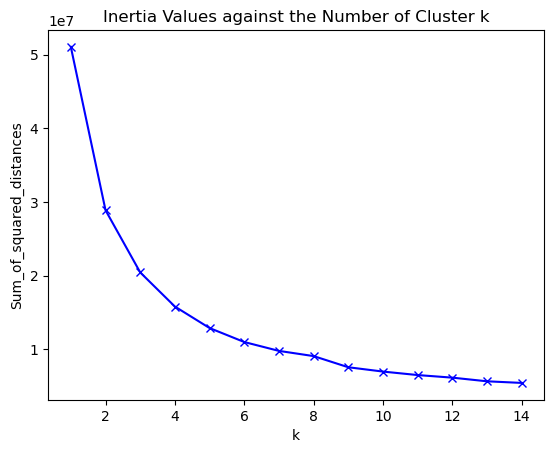

In [13]:
sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(moment_lst, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

Text(0.5, 1.0, 'ALL TIMES K-means clustering result, 6 clusters')

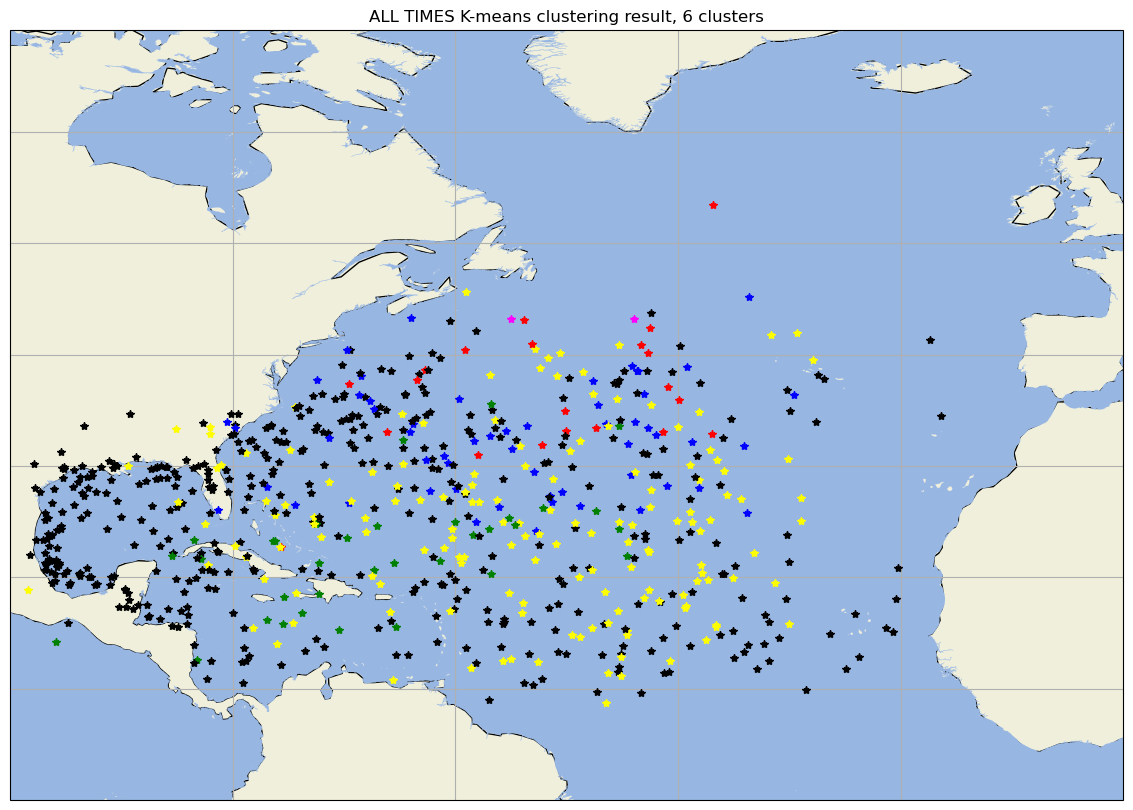

In [31]:
km = k_means(moment_lst, n_clusters=6)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']
labels = km[1]
ax = map_background()
for k in range(len(moment_lst)):
    ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels[k]], marker='*')
plt.title('ALL TIMES K-means clustering result, 6 clusters')

### Cluster for data 1950-2023

In [189]:
#storm_ind_1950 = 1149
#storm_ind_last = 2343

In [23]:
tks_1950_2024 = sel_years(tks,1950,2024)

In [24]:
moment_lst = [get_moments(tks_1950_2024.sel(storm=i)) for i in range(tks_1950_2024.dims['storm'])
              if get_moments(tks_1950_2024.sel(storm=i))]

Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k')

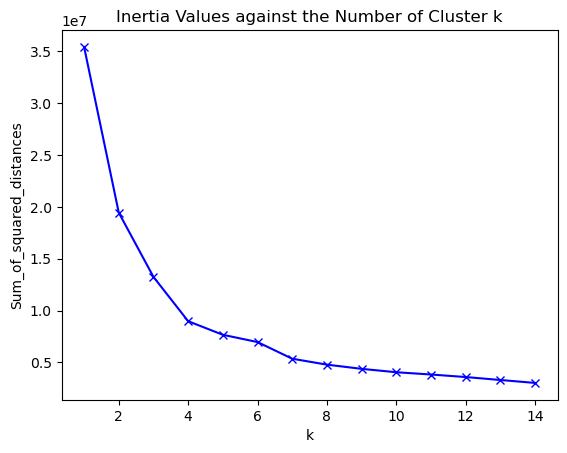

In [25]:
sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(moment_lst, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

Text(0.5, 1.0, '1950-2023 K-means clustering result, 6 clusters')

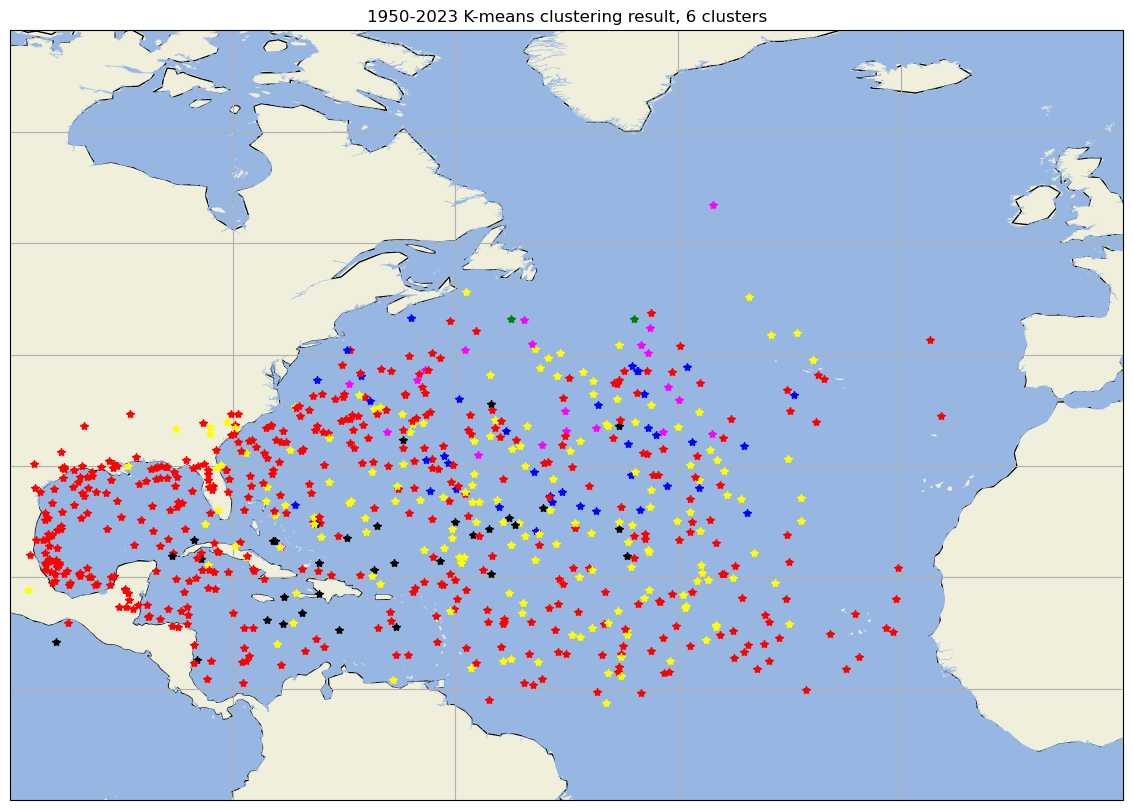

In [33]:
km = k_means(moment_lst, n_clusters=6)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']
labels = km[1]
ax = map_background()
for k in range(len(moment_lst)):
    ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels[k]], marker='*')
plt.title('1950-2023 K-means clustering result, 6 clusters')

### Cluster for data 1980-2023

In [27]:
tks_1980_2024 = sel_years(tks,1980,2024)

In [28]:
moment_lst = [get_moments(tks_1980_2024.sel(storm=i)) for i in range(tks_1980_2024.dims['storm'])
              if get_moments(tks_1980_2024.sel(storm=i))]

Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k')

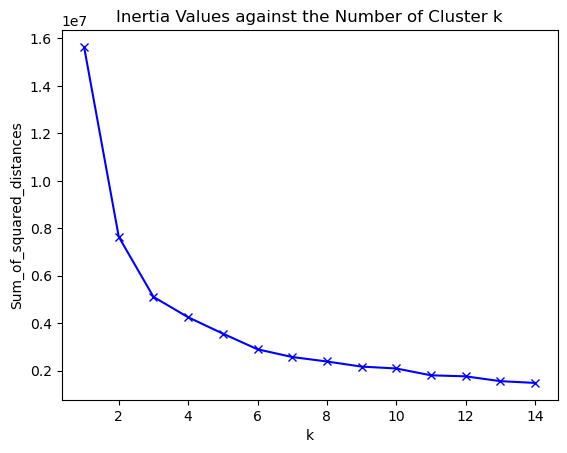

In [29]:
sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(moment_lst, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

Text(0.5, 1.0, '1980-2023 K-means clustering result, 6 clusters')

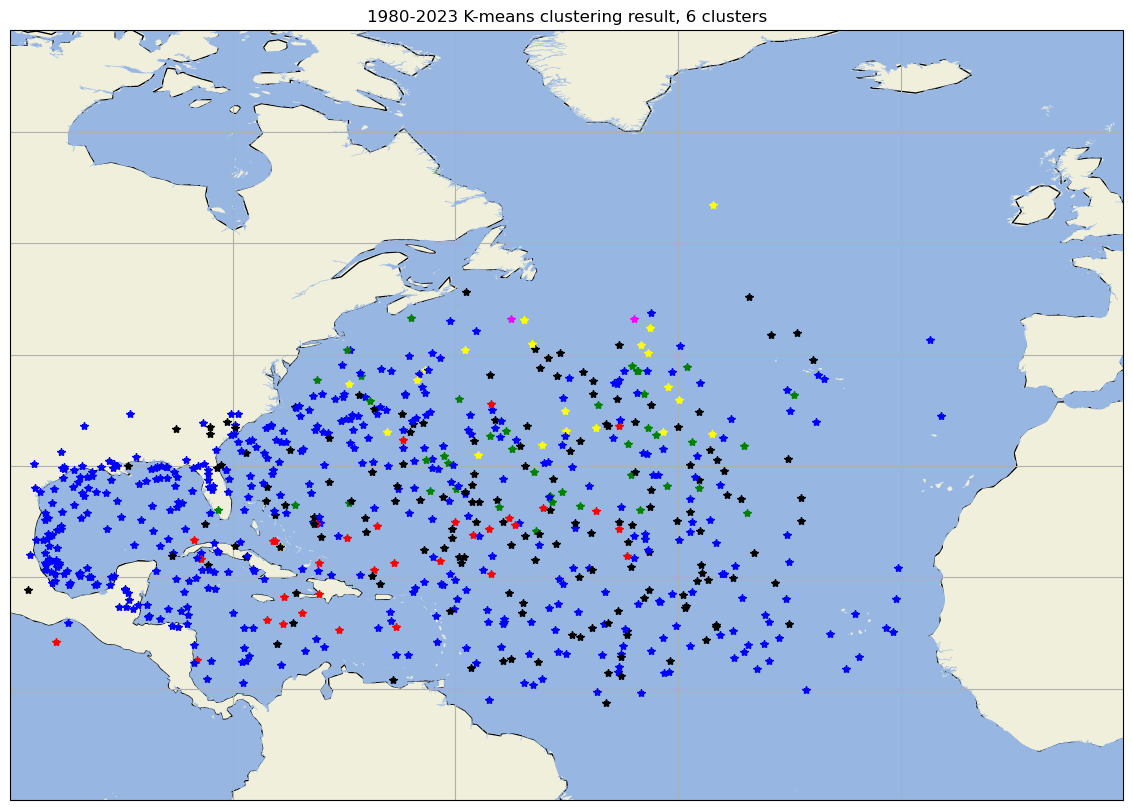

In [34]:
km = k_means(moment_lst, n_clusters=6)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']
labels = km[1]
ax = map_background()
for k in range(len(moment_lst)):
    ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels[k]], marker='*')
plt.title('1980-2023 K-means clustering result, 6 clusters')